In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import imageio
from IPython.display import Video
from typing import Sequence
import warnings
warnings.filterwarnings("ignore")

In [2]:
class MolecularDynamic:
    """
    the class to simulate Molecular Dynamic model
    """

    def __init__(self, N: int,sigma: float, epsilon: float, length: int) -> None:
        """
        the function to initialize the MD model

        :param N:the number of molecules
        :type N:int
        :param sigma:the distance param of the force
        :type sigma:float
        :param epsilon:the energy param of the force
        :type epsilon:float
        :param length:the size of the box
        :type length:int

        leftSideTrajectory is the trajectory of the number of molecules in the lft size of the box
        uTrajectory is the trajectory of the potential energy
        xTrajectory is the trajectory of the position of the molecules
        tempTrajectory is the trajectory of the temperature of the system
        rc is the threshold of the distance(we are gonna ignore further distances)
        a is the param for distance between molecules at the initial condition
        we set all of them at the left in a certain distance
        """

        self.T = None
        self.delta = None
        self.leftSideTrajectory = None
        self.uTrajectory = None
        self.xTrajectory = None
        self.length = length
        self.N = N
        self.epsilon = epsilon
        self.sigma = sigma
        self.rc = 2.5 * sigma

        a = int(1/(1/(2*N))**(1/2))
        # creating available positions based on a
        X = np.zeros((len( np.linspace(0,1,a+1)) * len(np.linspace(0,0.5,a//2)),2))
        for i,j in enumerate(itertools.product( np.linspace(0.1,0.9,a+1),np.linspace(0,0.5,a//2))):
            X[i] = j

        self.x = self.length * X[:N,0] +  self.length * X[:N,1]*1J#choosing the first N available position


        distances = self.getDistanceMatrix(self.x)
        rMag = np.sqrt(np.square(distances.real) +  np.square(distances.imag))  # magnitude of r
        filter = (rMag < self.rc)  #filtering the far particles
        self.U = self.getU(rMag,filter)


    def run(self, T: float, delta:float, bigSteps: int, smallSteps: int) -> None:
        """
        the function to go further in time for "bigStep * smallSteps" step of "dt"
        :param T: the temerature of the system
        :type T: float
        :param delta: the shift param in MC
        :type delta: float
        :param bigSteps: the big steps which data gathering happens after each
        :type bigSteps: int
        :param smallSteps: the small steps of MC
        :type smallSteps: int
        """
        self.T = T
        self.delta = delta

        #random numbers
        randomNs = np.random.randint(0,self.N,bigSteps * smallSteps)
        randomShifts = self.delta * (2*np.random.random((bigSteps*smallSteps ,2 )) -1 )
        randomShifts = randomShifts[:,0] + randomShifts[:,1]*1J
        randomValues = np.random.rand(bigSteps * smallSteps)

        #initializing the trajectories

        self.xTrajectory = np.zeros((bigSteps,self.N),dtype=np.complex128)
        self.uTrajectory = np.zeros(bigSteps)
        self.leftSideTrajectory = np.zeros(bigSteps)

        #main loop
        for i in range(bigSteps):
            print(i)  #to see the process is running

            for j in range(smallSteps):
                self.step(randomNs[i * smallSteps  +j],randomShifts[i * smallSteps  +j],randomValues[i * smallSteps  +j])

            #storing data
            self.xTrajectory[i]  = self.x
            self.uTrajectory[i]  = self.U
            self.leftSideTrajectory[i]  = self.getLeftSidedNum()


    def step(self, n: int, shift: np.ndarray, randomValue: np.ndarray) -> None:
        """
        the steps of MC

        :param n:the index of selected particle
        :type n:int
        :param shift: the random shift on position of selected particle
        :type shift: np.ndarray
        :param randomValue: the random value in MC condition
        :type randomValue: np.ndarray
        """
        x = self.x.copy()
        x[n] += shift
        x = self.getRebounded(x)

        newDistances = self.getDistanceMatrix(x)
        rMag = np.sqrt(np.square(newDistances.real) +  np.square(newDistances.imag))  # magnitude of r
        filter = (rMag < self.rc)  #filtering the far particles
        newU = self.getU(rMag,filter)
        dU = newU - self.U

        if (dU<0) or (randomValue < np.exp(-dU/self.T)):
            self.x = x
            self.U = newU

    def getLeftSidedNum(self) -> np.ndarray:
        """
        the function to get the number of molecules on the left side of the box

        :return: number of molecules on the left side of the box
        :rtype: np.ndarray
        """
        return np.sum(self.x.imag<=self.length/2)


    def animate(self, trajectory: np.ndarray, name: str, jump: int, steps: int, T: float, delta: float) -> None:
        """
        the function to animate the trajectory of the system and save it as the name.

        :param jump: the interval
        :type jump: int
        :param steps: the total steps
        :type steps: int
        :param T: the temp of system
        :type T: float
        :param delta: the MC shift param
        :type delta: float
        :param trajectory:the input trajectory
        :type trajectory:np.ndarray
        :param name:the name ot save the video
        :type name: str
        """
        images = []
        for i in range(len(trajectory)//jump):
            plt.clf()
            plt.title("Animating md Model for steps={0} size={1} , T={2} , delta={3}".format(steps,self.length,T,delta))
            plt.scatter(trajectory[i*jump,:].real,trajectory[i*jump,:].imag,c="blue",s=1)
            plt.xlim((0,self.length))
            plt.ylim((0,self.length))
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.savefig(str(i)+".png")
            images.append(imageio.imread(str(i)+".png"))

        imageio.mimsave('{}.mp4'.format(name), images)
        Video('{}.mp4'.format(name))

    def getDistanceMatrix(self, x: np.ndarray) -> np.ndarray:
        """
        the function to get the matrix of distances of particles by tiling up the positions and subtracting the positions from each other

        :param x:the input positions of particles
        :type x: np.ndarray
        :return: the matrix of distances of particles
        :rtype: np.array
        """
        distances = np.zeros((1,self.N,self.N),dtype=complex)
        tiledPoses = np.tile(x, (self.N, 1))
        np.subtract(tiledPoses, np.transpose(tiledPoses), distances)

        distances = distances.reshape((self.N,self.N))
        distances = ((distances.real + self.length/2) % self.length - self.length/2) + 1J*((distances.imag+ self.length/2) % self.length - self.length/2)

        return distances

    def getU(self, rMag: np.ndarray, filter: np.ndarray) -> np.ndarray:
        """
        th function to calculate the total potential energy of the system

        :param rMag:the magnitude of the distances
        :type rMag: np.ndarray
        :param filter: the filter on far particles
        :type filter: np.ndarray
        :return: the total potential energy of the system
        :rtype: np.ndarray
        """
        Us = 4*self.epsilon*( (self.sigma/rMag)**12  - (self.sigma/rMag)**6)
        Us = np.where(np.isnan(Us),0,Us)  # ignoring where U explodes for example U(rii)
        return np.sum(Us*filter)/2


    def getRebounded(self, xNew: np.ndarray) -> np.ndarray:
        """
        the function to rebound the positions using reminder of positions on length
        :param xNew: the unbounded positions
        :type xNew: np.array
        :return: rebounded positions
        :rtype: np.array
        """
        return (xNew.real % self.length) + (xNew.imag % self.length)*1J


## Main Part:(T = 1)

In [7]:
md = MolecularDynamic(100,1,1,40)

In [8]:
bigSteps = 1000
smallSteps = 1000

In [9]:
md.run(1,1,bigSteps,smallSteps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27


### part 0:

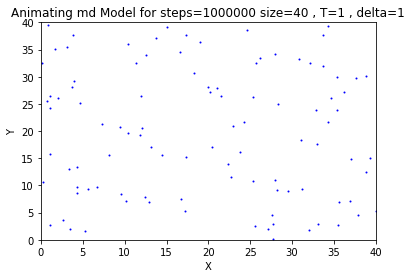

In [13]:
md.animate(md.xTrajectory,"part0_1mc",1,1000000,1,1)

### part 1:

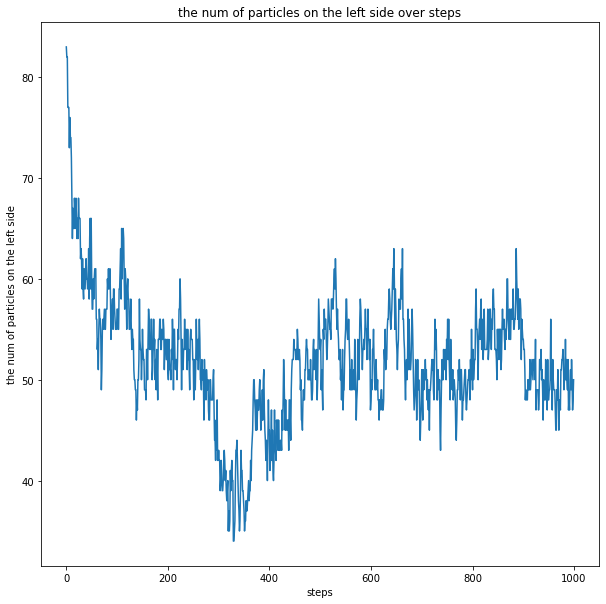

In [11]:
plt.figure(figsize=(10,10))
plt.title("the num of particles on the left side over steps")
plt.xlabel("steps")
plt.ylabel("the num of particles on the left side")
plt.plot(np.arange(bigSteps),md.leftSideTrajectory)
plt.show()

### part 2:

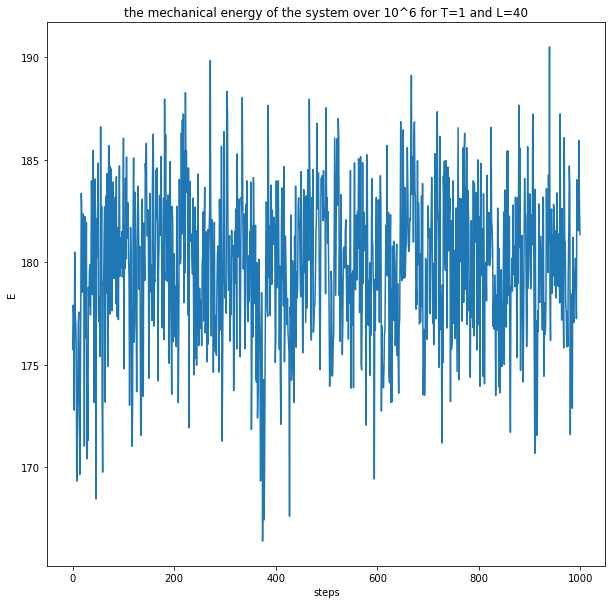

In [14]:
plt.figure(figsize=(10,10))
plt.title("the mechanical energy of the system over 10^6 for T=1 and L=40")
plt.xlabel("steps")
plt.ylabel("E")
plt.plot(np.arange(bigSteps),md.uTrajectory + (2*md.N*md.T))
plt.show()

## Main Part:(T = 0.01)

In [15]:
md = MolecularDynamic(100,1,1,50)

In [16]:
bigSteps = 1000
smallSteps = 1000

In [17]:
md.run(0.01,1,bigSteps,smallSteps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

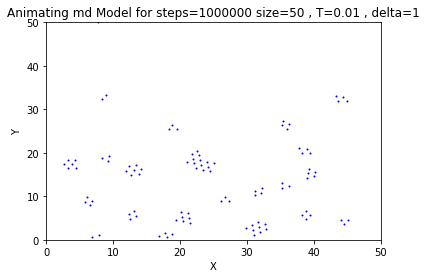

In [23]:
md.animate(md.xTrajectory,"part0_2mc",1,1000000,0.01,1)

### part 1:

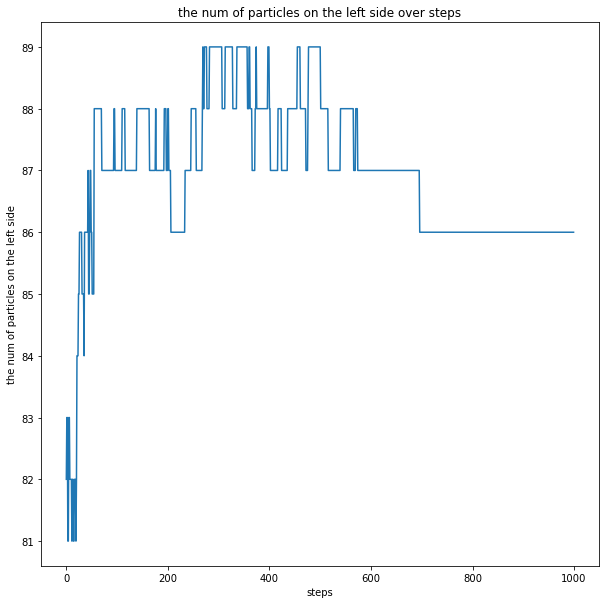

In [21]:
plt.figure(figsize=(10,10))
plt.title("the num of particles on the left side over steps")
plt.xlabel("steps")
plt.ylabel("the num of particles on the left side")
plt.plot(np.arange(bigSteps),md.leftSideTrajectory)
plt.show()

### part 2:

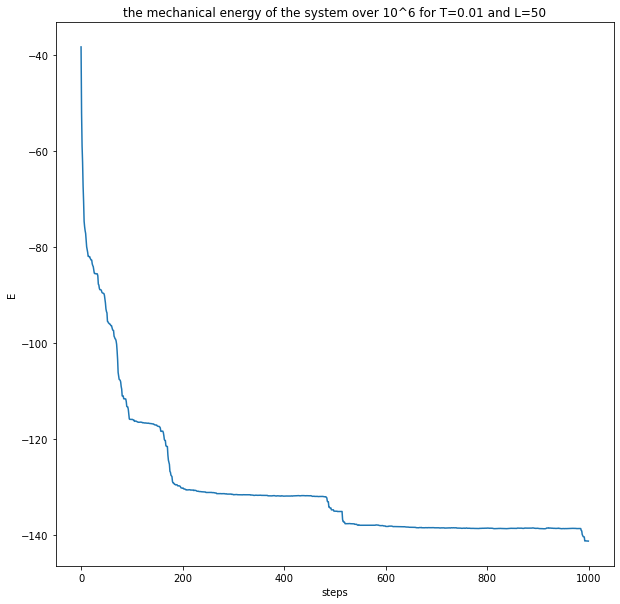

In [22]:
plt.figure(figsize=(10,10))
plt.title("the mechanical energy of the system over 10^6 for T=0.01 and L=50")
plt.xlabel("steps")
plt.ylabel("E")
plt.plot(np.arange(bigSteps),md.uTrajectory + (2*md.N*md.T))
plt.show()